<a href="https://colab.research.google.com/github/amandatz/computational-linear-algebra/blob/main/Atividade6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade 6

Amanda Topanotti Zanette (22100776)

**Importações e funções auxiliares**

In [29]:
using LinearAlgebra, SparseArrays, Plots


Esse trecho de código é usado apenas para garantir a repetibilidade dos números aleatórios gerados.

In [30]:
using Random
Random.seed!(123)

TaskLocalRNG()

### Questão 1

In [43]:
function gauss_seidel(A, b, x0; tol=1e-8, max_iter=1000)
  n = length(b)
  x = copy(x0)
  residuals = Float64[]
  residual = norm(A * x - b)
  push!(residuals, residual)

  for iter in 1:max_iter
    x_old = copy(x)

    for i in 1:n
      sum_updated = dot(A[i, 1:i-1], x[1:i-1])
      sum_not_updated = dot(A[i, i+1:n], x_old[i+1:n])

      x[i] = (b[i] - sum_updated - sum_not_updated) / A[i, i]
    end

    residual = norm(A * x - b)
    push!(residuals, residual)

    if residual < tol
      println("Convergência alcançada após $iter iterações")
      return x, residuals, iter
    end
  end

  println("Máximo de iterações alcançado sem convergência")
  return x, residuals, max_iter
end

gauss_seidel (generic function with 1 method)

In [32]:
function gradiente_conjugado(A, b, x0; max_iter=2000, tol=1e-8)
    x = copy(x0)
    r = b - A*x
    p = copy(r)
    rsold = dot(r, r)
    residuals = Vector{Float64}(undef, max_iter+1)
    residuals[1] = sqrt(rsold)

    for iter in 1:max_iter
        Ap = A*p
        α = rsold / dot(p, Ap)
        x .+= α .* p
        r .-= α .* Ap
        rsnew = dot(r, r)
        residuals[iter+1] = sqrt(rsnew)

        if sqrt(rsnew) < tol
            resize!(residuals, iter+1)
            println("Convergência após $iter iterações")
            return x, residuals, iter
        end

        β = rsnew / rsold
        p .= r .+ β .* p
        rsold = rsnew
    end
    println("Máximo de iterações alcançado")
    return x, residuals, max_iter
end

gradiente_conjugado (generic function with 1 method)

### Questão 2

In [33]:
function matriz_bloco_tridiagonal(m::Int, n::Int)
    # Cria o bloco T diretamente no formato esparso
    T = spdiagm(-1 => fill(-1.0, n-1), 0 => fill(4.0, n), 1 => fill(-1.0, n-1))

    # Cria a matriz bloco-tridiagonal usando a função kron otimizada
    A = kron(I(m), T)

    # Adiciona os blocos -I fora da diagonal
    I_bloco = spdiagm(0 => fill(-1.0, n))
    for k in 1:m-1
        rows = (k-1)*n+1:k*n
        cols = k*n+1:(k+1)*n
        A[rows, cols] = I_bloco
        A[cols, rows] = I_bloco
    end
    return A
end

matriz_bloco_tridiagonal (generic function with 2 methods)

In [41]:
function testar_sistemas(m, ns)
    for n in ns
        println("\n========================================")
        println("Resolvendo para m = $m, n = $n")
        println("Tamanho da matriz: $(m*n)×$(m*n)")
        println("========================================")

        @time begin
            A = matriz_bloco_tridiagonal(m, n)
            e = ones(m*n)
            b = A*e
            x0 = zeros(m*n)

            println("\nGradiente Conjugado:")
            @time x_gc, res_gc, iter_gc = gradiente_conjugado(A, b, x0)

            println("\nGauss-Seidel:")
            @time x_gs, res_gs, iter_gs = gauss_seidel(A, b, x0)

            # Plotagem
            p = plot(title="Comparação para n=$n (Tamanho $(m*n)×$(m*n))",
                    xlabel="Iterações", ylabel="‖r‖₂ (log)",
                    yscale=:log10, legend=:topright)

            plot!(p, res_gc, label="Grad. Conjugado ($iter_gc iter)", lw=2)
            plot!(p, res_gs, label="Gauss-Seidel ($iter_gs iter)", lw=2)

            display(p)
            savefig(p, "comparacao_n$(n)_optimized.png")
        end
    end
end

testar_sistemas (generic function with 1 method)


Resolvendo para m = 10, n = 10
Tamanho da matriz: 100×100

Gradiente Conjugado:
  0.000024 seconds (22 allocations: 17.094 KiB)

Gauss-Seidel:
Convergência alcançada após 229 iterações
  0.050919 seconds (228.80 k allocations: 33.611 MiB)


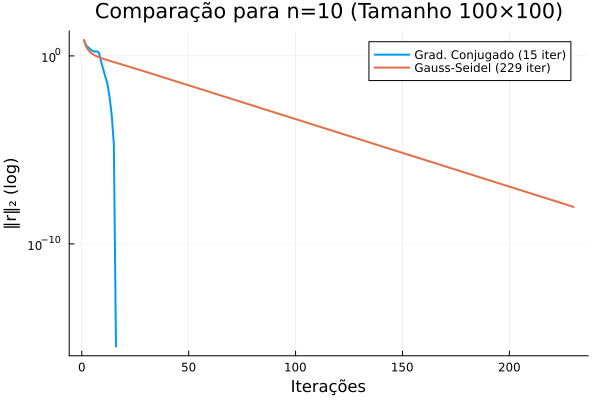

  0.171708 seconds (248.67 k allocations: 35.971 MiB)

Resolvendo para m = 10, n = 100
Tamanho da matriz: 1000×1000

Gradiente Conjugado:
  0.001395 seconds (88 allocations: 668.672 KiB)

Gauss-Seidel:
Convergência alcançada após 467 iterações
  3.999013 seconds (4.67 M allocations: 3.861 GiB, 6.00% gc time)


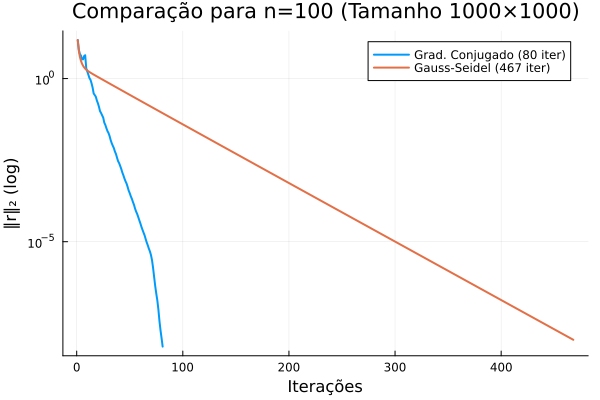

  4.168256 seconds (4.69 M allocations: 3.865 GiB, 5.76% gc time)

Resolvendo para m = 10, n = 1000
Tamanho da matriz: 10000×10000

Gradiente Conjugado:
  0.018148 seconds (212 allocations: 7.941 MiB)

Gauss-Seidel:
Convergência alcançada após 503 iterações
284.922449 seconds (58.30 M allocations: 378.391 GiB, 2.12% gc time)


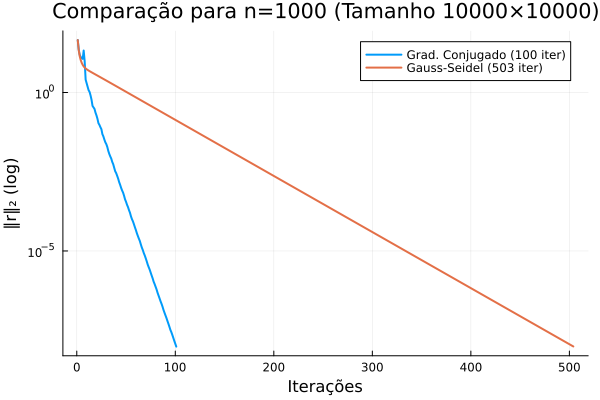

285.079849 seconds (58.32 M allocations: 378.414 GiB, 2.12% gc time)


In [44]:

# Executar teste
testar_sistemas(10, [10, 100, 1000])

### Questão 3

In [38]:
function gerar_matriz_espectral(autovalores::Vector{Float64})
    n = length(autovalores)
    # Passo 1: Gerar matriz aleatória e sua decomposição QR
    M = randn(n, n)
    Q, _ = qr(M)  # Q é ortogonal

    # Passo 2: Construir a matriz simétrica usando autovalores
    # Aqui evitamos criar a matriz diagonal explicitamente
    A = zeros(n, n)
    for i in 1:n
        λ = autovalores[i]
        q = Q[:, i]
        A .+= λ * (q * q')  # Rank-1 update
    end
    return Symmetric(A)
end

gerar_matriz_espectral (generic function with 1 method)

In [39]:
using LinearAlgebra

# 1. Gerar matrizes especiais (sem usar diagonal)
function criar_matriz(autovalores)
    n = length(autovalores)
    Q = randn(n, n) |> qr |> x -> x.Q  # Matriz aleatória ortogonal
    return Q * Diagonal(autovalores) * Q'  # Monta a matriz simétrica
end

# 2. Criar os 3 casos pedidos
autovalores_a = range(1, 1000, length=1000)  # Uniforme 1 a 1000
autovalores_b = repeat(100:100:1000, inner=100)  # 100,200,...,1000 (cada 100x)
autovalores_c = repeat([1, 100000], inner=500)   # 1 e 100000 (cada 500x)

A1 = criar_matriz(autovalores_a)
A2 = criar_matriz(autovalores_b)
A3 = criar_matriz(autovalores_c)

# 3. Gradiente Conjugado simples
function GC(A, b, x0; max_iter=1000, tol=1e-8)
    x = copy(x0)
    r = b - A*x
    p = copy(r)
    for iter in 1:max_iter
        α = dot(r, r) / dot(p, A*p)
        x += α * p
        r_novo = r - α * A*p
        if norm(r_novo) < tol
            return x, iter
        end
        β = dot(r_novo, r_novo) / dot(r, r)
        p = r_novo + β * p
        r = r_novo
    end
    return x, max_iter
end

# 4. Testar com b = A*e (e = vetor de 1s)
e = ones(1000)
x0 = zeros(1000)

# Teste para A1
b1 = A1 * e
x1, iter1 = GC(A1, b1, x0)
println("Caso A1 (uniforme): convergiu em $iter1 iterações")

# Teste para A2
b2 = A2 * e
x2, iter2 = GC(A2, b2, x0)
println("Caso A2 (escalonado): convergiu em $iter2 iterações")

# Teste para A3
b3 = A3 * e
x3, iter3 = GC(A3, b3, x0)
println("Caso A3 (extremos): convergiu em $iter3 iterações")

Caso A1 (uniforme): convergiu em 209 iterações
Caso A2 (escalonado): convergiu em 10 iterações
Caso A3 (extremos): convergiu em 3 iterações
